# 1. Import and Install Dependencies

## 1.1 Install Dependencies

In [1]:
!pip3 install  matplotlib tensorflow tensorflow-io

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


## 1.2 Load Dependencies

In [2]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio

2023-03-30 10:57:11.750056: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-30 10:57:11.750092: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# 2. Build Data Loading Function

## 2.1 Define Paths to Files

In [3]:
CAPUCHIN_FILE = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

## 2.2 Build Dataloading Function

In [4]:
def preprocess(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Using tf -> Decode wav we are changing the wave to mono / single channel 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

## 2.3 Plot Wave

In [5]:
wave = preprocess(CAPUCHIN_FILE)
nwave = preprocess(NOT_CAPUCHIN_FILE)

2023-03-30 10:57:13.492370: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-30 10:57:13.492405: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-30 10:57:13.492430: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (064bed5cf7b1): /proc/driver/nvidia/version does not exist
2023-03-30 10:57:13.493427: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-30 10:57:13.550254: W tensorflow_io/core/kernels/audio_video_mp3_kernels.cc:271] libmp3lame.so

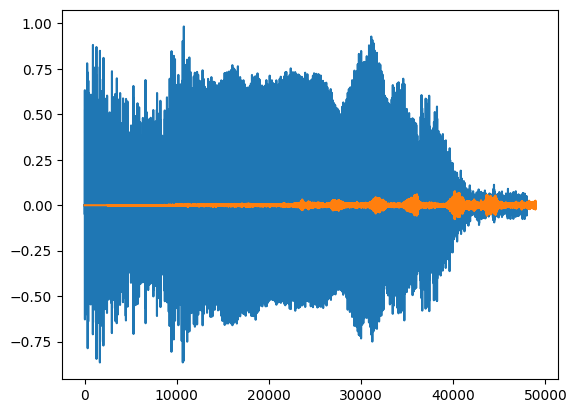

In [6]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

There is stark difference in our class 0 and class 1 wave spectograph and we will try to exploit this separation 

# 3. Create Tensorflow Dataset

## 3.1 Define Paths to Positive and Negative Data

In [7]:
POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

## 3.2 Create Tensorflow Datasets

In [8]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

## 3.3 Add labels and Combine Positive and Negative Samples

In [9]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

# 4. Determine Average Length of a Capuchin Call

## 4.1 Calculate Wave Cycle Length

In [10]:
lengths = []
for file in os.listdir(os.path.join('data', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = preprocess(os.path.join('data', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

## 4.2 Calculate Mean, Min and Max

In [11]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [12]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [13]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

# 5. Build Preprocessing Function to Convert to Spectrogram

## 5.1 Build Preprocessing Function

In [14]:
def preprocess(file_path, label): 
    wav = preprocess(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

## 5.2 Test Out the Function and Viz the Spectrogram

In [15]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [16]:
spectrogram, label = preprocess(filepath, label)

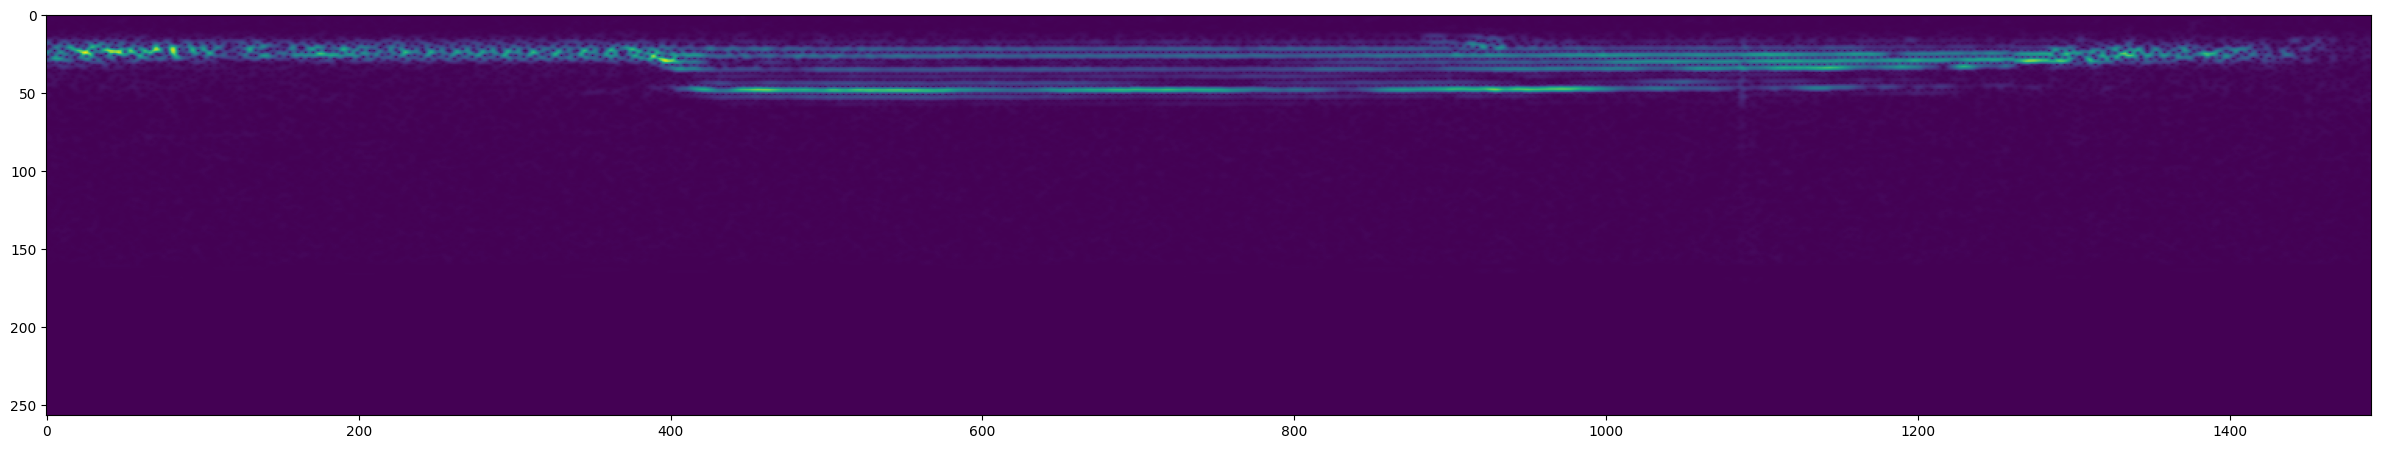

In [17]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# 6. Create Training and Testing Partitions

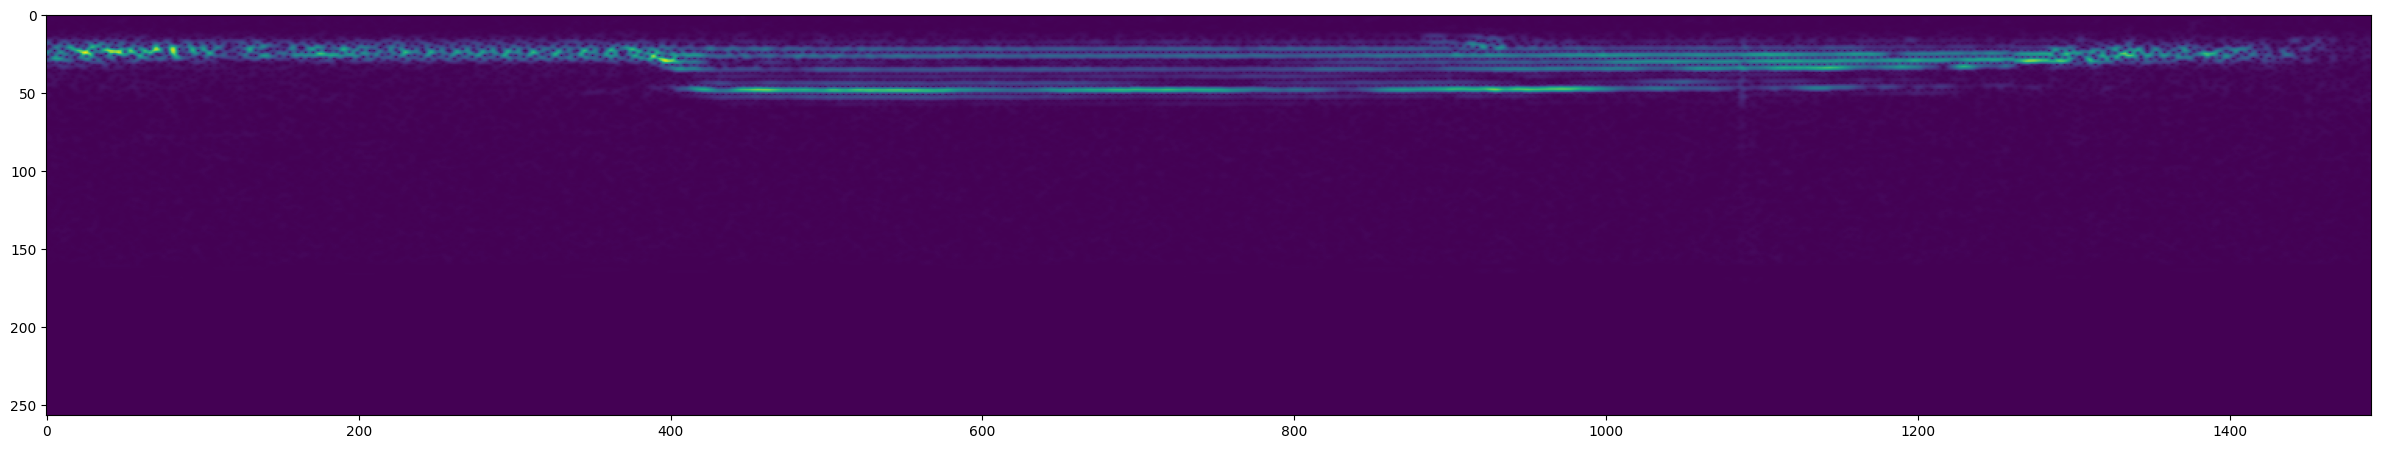## 6.1 Create a Tensorflow Data Pipeline

In [18]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

## 6.2 Split into Training and Testing Partitions

In [19]:
train = data.take(36)
test = data.skip(36).take(15)

## 6.3 Test One Batch

In [20]:
samples, labels = train.as_numpy_iterator().next()

In [21]:
samples.shape

(16, 1491, 257, 1)

# 7. Build Deep Learning Model

## 7.1 Load Tensorflow Dependencies

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

## 7.2 Build Sequential Model, Compile and View Summary

In [23]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

2023-03-30 10:57:26.980198: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3081920512 exceeds 10% of free system memory.
2023-03-30 10:57:27.662509: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3081920512 exceeds 10% of free system memory.
2023-03-30 10:57:28.064306: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3081920512 exceeds 10% of free system memory.


In [24]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 flatten (Flatten)           (None, 6019376)           0         
                                                                 
 dense (Dense)               (None, 128)               770480256 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 770,482,865
Trainable params: 770,482,865
Non-trainable params: 0
_________________________________________________________________


## 7.3 Fit Model, View Loss and KPI Plots

In [26]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4


2023-03-30 10:57:28.793667: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3081920512 exceeds 10% of free system memory.
2023-03-30 10:57:29.055218: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3081920512 exceeds 10% of free system memory.


36/36 [==============================] - 331s 9s/step - loss: 2.1385 - recall: 0.9216 - precision: 0.8981 - val_loss: 0.0091 - val_recall: 1.0000 - val_precision: 0.9833
Epoch 2/4
36/36 [==============================] - 431s 12s/step - loss: 0.0617 - recall: 0.9733 - precision: 0.9669 - val_loss: 0.0267 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 3/4
36/36 [==============================] - 368s 10s/step - loss: 0.0386 - recall: 0.9869 - precision: 0.9869 - val_loss: 0.0050 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/4
36/36 [==============================] - 447s 12s/step - loss: 0.0025 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0490 - val_recall: 1.0000 - val_precision: 0.9688


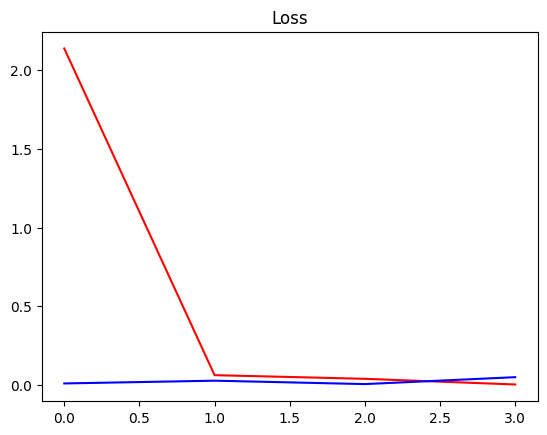

In [27]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

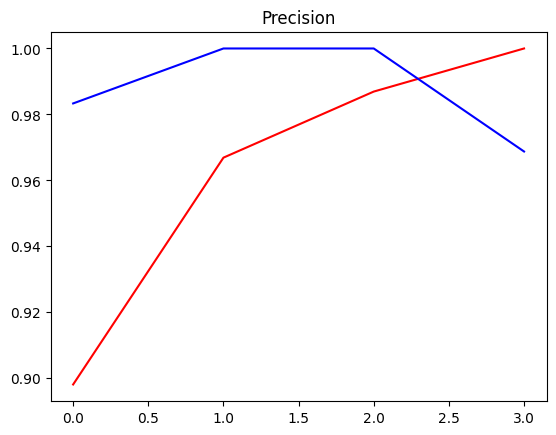

In [28]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

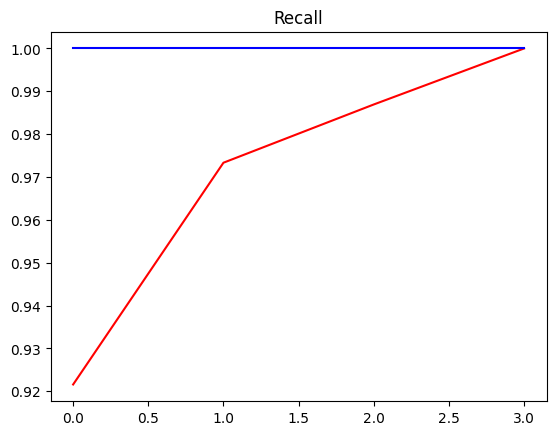

In [29]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

# 8. Make a Prediction on a Single Clip

## 8.1 Get One Batch and Make a Prediction

In [30]:
X_test, y_test = test.as_numpy_iterator().next()

In [31]:
yhat = model.predict(X_test)

## 8.2 Convert Logits to Classes 

In [32]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

# 9. Build Forest Parsing Functions

## 9.1 Load up MP3s

In [33]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [34]:
mp3 = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')

In [35]:
wav = load_mp3_16k_mono(mp3)

In [36]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [37]:
samples, index = audio_slices.as_numpy_iterator().next()

## 9.2 Build Function to Convert Clips into Windowed Spectrograms

In [38]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

## 9.3 Convert Longer Clips into Windows and Make Predictions

In [39]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [40]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

## 9.4 Group Consecutive Detections

In [41]:
from itertools import groupby

In [42]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [43]:
calls

6

# 10. Make Predictions

## 10.1 Loop over all recordings and make predictions

In [44]:
results = {}
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
    FILEPATH = os.path.join('data','Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

In [45]:
results

{'recording_88.mp3': array([[0.0000000e+00],
        [7.0155726e-36],
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        [2.3823824e-34],
        [4.8386376e-38],
        [1.2902598e-32],
        [2.9446953e-38],
        [2.4664124e-35],
        [7.0341306e-32],
        [4.8896530e-35],
        [2.1221402e-32],
        [5.7046513e-33],
        [2.3609868e-33],
        [3.3821785e-32],
        [1.1730165e-33],
        [1.5057960e-36],
        [8.6715771e-35],
        [1.4563893e-32],
        [2.3092932e-36],
        [3.1658458e-37],
        [0.0000000e+00],
        [3.1922448e-38],
        [5.0762896e-37],
        [1.4180203e-31],
        [0.0000000e+00],
        [4.1776220e-35],
        [2.4549175e-32],
        [1.4812489e-33],
        [6.8050111e-31],
        [1.0826966e-33],
        [1.3647036e-35],
        [7.7922114e-35],
        [0.0000000e+00],
        [1.4562481e-35],
        [4.5132821e-34],
        [1.9737107e-32],
        [4.3659396e-33],
     

## 10.2 Convert Predictions into Classes

In [46]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

{'recording_88.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_63.mp3': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'recording_81.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_83.mp3': [0,
  0,
  0,
  

## 10.3 Group Consecutive Detections

In [47]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_88.mp3': 0,
 'recording_63.mp3': 1,
 'recording_81.mp3': 5,
 'recording_83.mp3': 0,
 'recording_08.mp3': 13,
 'recording_65.mp3': 5,
 'recording_01.mp3': 0,
 'recording_49.mp3': 0,
 'recording_91.mp3': 0,
 'recording_36.mp3': 3,
 'recording_93.mp3': 7,
 'recording_31.mp3': 1,
 'recording_10.mp3': 5,
 'recording_59.mp3': 1,
 'recording_37.mp3': 5,
 'recording_41.mp3': 0,
 'recording_78.mp3': 1,
 'recording_34.mp3': 5,
 'recording_70.mp3': 4,
 'recording_28.mp3': 1,
 'recording_45.mp3': 3,
 'recording_94.mp3': 3,
 'recording_30.mp3': 3,
 'recording_77.mp3': 1,
 'recording_19.mp3': 4,
 'recording_22.mp3': 2,
 'recording_90.mp3': 0,
 'recording_85.mp3': 0,
 'recording_21.mp3': 1,
 'recording_09.mp3': 0,
 'recording_26.mp3': 2,
 'recording_51.mp3': 2,
 'recording_95.mp3': 5,
 'recording_58.mp3': 0,
 'recording_13.mp3': 0,
 'recording_43.mp3': 5,
 'recording_00.mp3': 6,
 'recording_98.mp3': 13,
 'recording_73.mp3': 0,
 'recording_23.mp3': 5,
 'recording_02.mp3': 0,
 'recording_29

# 11. Export Results

In [48]:
import csv

In [49]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])